In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# PATCH: Fix for NumPy compatibility with Gym
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# Initialize CartPole environment using new Gym API
env = gym.make("CartPole-v1", render_mode=None, new_step_api=True)

# Define DQN Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Get dimensions from env
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

# Hyperparameters
lr = 1e-3
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 300
batch_size = 64
memory = deque(maxlen=10000)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DQN(input_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randrange(output_dim)
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        return model(state).argmax().item()

# Training step
def train_step():
    if len(memory) < batch_size:
        return
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = model(states).gather(1, actions)
    with torch.no_grad():
        max_next_q = model(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * gamma * max_next_q

    loss = criterion(q_values.squeeze(), target_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
for ep in range(episodes):
    reset_result = env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

    total_reward = 0
    done = False

    while not done:
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.append((state, action, reward, next_state, float(done)))
        state = next_state
        total_reward += reward
        train_step()

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {ep + 1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")



Episode 1, Reward: 9.0, Epsilon: 0.995
Episode 2, Reward: 12.0, Epsilon: 0.990
Episode 3, Reward: 29.0, Epsilon: 0.985
Episode 4, Reward: 14.0, Epsilon: 0.980
Episode 5, Reward: 16.0, Epsilon: 0.975
Episode 6, Reward: 12.0, Epsilon: 0.970


<ipython-input-1-782350e2c53a>:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states).to(device)


Episode 7, Reward: 29.0, Epsilon: 0.966
Episode 8, Reward: 44.0, Epsilon: 0.961
Episode 9, Reward: 35.0, Epsilon: 0.956
Episode 10, Reward: 28.0, Epsilon: 0.951
Episode 11, Reward: 22.0, Epsilon: 0.946
Episode 12, Reward: 16.0, Epsilon: 0.942
Episode 13, Reward: 11.0, Epsilon: 0.937
Episode 14, Reward: 19.0, Epsilon: 0.932
Episode 15, Reward: 11.0, Epsilon: 0.928
Episode 16, Reward: 16.0, Epsilon: 0.923
Episode 17, Reward: 16.0, Epsilon: 0.918
Episode 18, Reward: 12.0, Epsilon: 0.914
Episode 19, Reward: 35.0, Epsilon: 0.909
Episode 20, Reward: 10.0, Epsilon: 0.905
Episode 21, Reward: 32.0, Epsilon: 0.900
Episode 22, Reward: 44.0, Epsilon: 0.896
Episode 23, Reward: 13.0, Epsilon: 0.891
Episode 24, Reward: 20.0, Epsilon: 0.887
Episode 25, Reward: 25.0, Epsilon: 0.882
Episode 26, Reward: 18.0, Epsilon: 0.878
Episode 27, Reward: 18.0, Epsilon: 0.873
Episode 28, Reward: 28.0, Epsilon: 0.869
Episode 29, Reward: 18.0, Epsilon: 0.865
Episode 30, Reward: 11.0, Epsilon: 0.860
Episode 31, Reward:

In [2]:

import os
import torch

BASELINE_MODEL_PATH = "baseline_model.pth"
NDLINEAR_MODEL_PATH = "ndlinear_model.pth"

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, input_dim, output_dim, device):
    model = model_class(input_dim, output_dim).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model


In [3]:
!git clone https://github.com/ensemble-core/NdLinear.git


Cloning into 'NdLinear'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 4), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 54.74 KiB | 1.16 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
import sys
sys.path.append("/content/NdLinear")  # or the local path where you cloned it




In [5]:
import gym
env = gym.make("CartPole-v1", render_mode=None, new_step_api=True)



In [6]:
def run_ndlinear(env, episodes=300, batch_size=64, lr=1e-3):
    import sys
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import random
    import numpy as np
    from collections import deque

    # Patch for Gym + NumPy
    if not hasattr(np, 'bool8'):
        np.bool8 = np.bool_

    # Add NdLinear repo to path (update if needed)
    sys.path.append("/content/NdLinear")

    # Import NdLinear
    from ndlinear import NdLinear

    # Define NdLinear-based DQN
    class DQN_NdLinear(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(DQN_NdLinear, self).__init__()
            self.net = nn.Sequential(
                NdLinear([input_dim], [128]),
                nn.ReLU(),
                NdLinear([128], [output_dim])
            )

        def forward(self, x):
            return self.net(x)

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DQN_NdLinear(input_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    memory = deque(maxlen=10000)

    # Training config
    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01
    rewards_nd = []

    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.randrange(output_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            return model(state).argmax().item()

    def train_step():
        if len(memory) < batch_size:
            return
        batch = random.sample(memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = model(states).gather(1, actions)
        with torch.no_grad():
            max_next_q = model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * gamma * max_next_q

        loss = criterion(q_values.squeeze(), target_q)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Training loop
    for ep in range(episodes):
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        total_reward = 0
        done = False

        while not done:
            action = select_action(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            memory.append((state, action, reward, next_state, float(done)))
            state = next_state
            total_reward += reward
            train_step()

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_nd.append(total_reward)
        print(f"[NdLinear] Episode {ep + 1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    return model, rewards_nd


In [7]:
nd_model, nd_rewards = run_ndlinear(env)


[NdLinear] Episode 1, Reward: 18.0, Epsilon: 0.995
[NdLinear] Episode 2, Reward: 63.0, Epsilon: 0.990
[NdLinear] Episode 3, Reward: 12.0, Epsilon: 0.985
[NdLinear] Episode 4, Reward: 11.0, Epsilon: 0.980
[NdLinear] Episode 5, Reward: 14.0, Epsilon: 0.975
[NdLinear] Episode 6, Reward: 13.0, Epsilon: 0.970
[NdLinear] Episode 7, Reward: 18.0, Epsilon: 0.966
[NdLinear] Episode 8, Reward: 15.0, Epsilon: 0.961
[NdLinear] Episode 9, Reward: 11.0, Epsilon: 0.956
[NdLinear] Episode 10, Reward: 22.0, Epsilon: 0.951
[NdLinear] Episode 11, Reward: 13.0, Epsilon: 0.946
[NdLinear] Episode 12, Reward: 12.0, Epsilon: 0.942
[NdLinear] Episode 13, Reward: 24.0, Epsilon: 0.937
[NdLinear] Episode 14, Reward: 11.0, Epsilon: 0.932
[NdLinear] Episode 15, Reward: 14.0, Epsilon: 0.928
[NdLinear] Episode 16, Reward: 12.0, Epsilon: 0.923
[NdLinear] Episode 17, Reward: 20.0, Epsilon: 0.918
[NdLinear] Episode 18, Reward: 17.0, Epsilon: 0.914
[NdLinear] Episode 19, Reward: 36.0, Epsilon: 0.909
[NdLinear] Episode 20

In [8]:
def run_baseline(env, episodes=300, batch_size=64, lr=1e-3):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import random
    import numpy as np
    from collections import deque

    # Patch for Gym + NumPy
    if not hasattr(np, 'bool8'):
        np.bool8 = np.bool_

    class DQN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(DQN, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Linear(128, output_dim)
            )

        def forward(self, x):
            return self.net(x)

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DQN(input_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    memory = deque(maxlen=10000)

    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01
    rewards_base = []

    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.randrange(output_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            return model(state).argmax().item()

    def train_step():
        if len(memory) < batch_size:
            return
        batch = random.sample(memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = model(states).gather(1, actions)
        with torch.no_grad():
            max_next_q = model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * gamma * max_next_q

        loss = criterion(q_values.squeeze(), target_q)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for ep in range(episodes):
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        total_reward = 0
        done = False

        while not done:
            action = select_action(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            memory.append((state, action, reward, next_state, float(done)))
            state = next_state
            total_reward += reward
            train_step()

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_base.append(total_reward)
        print(f"[Baseline] Episode {ep + 1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    return model, rewards_base


In [9]:
baseline_model, rewards_baseline = run_baseline(env)


[Baseline] Episode 1, Reward: 11.0, Epsilon: 0.995
[Baseline] Episode 2, Reward: 36.0, Epsilon: 0.990
[Baseline] Episode 3, Reward: 13.0, Epsilon: 0.985
[Baseline] Episode 4, Reward: 19.0, Epsilon: 0.980
[Baseline] Episode 5, Reward: 11.0, Epsilon: 0.975
[Baseline] Episode 6, Reward: 16.0, Epsilon: 0.970
[Baseline] Episode 7, Reward: 27.0, Epsilon: 0.966
[Baseline] Episode 8, Reward: 25.0, Epsilon: 0.961
[Baseline] Episode 9, Reward: 18.0, Epsilon: 0.956
[Baseline] Episode 10, Reward: 21.0, Epsilon: 0.951
[Baseline] Episode 11, Reward: 50.0, Epsilon: 0.946
[Baseline] Episode 12, Reward: 25.0, Epsilon: 0.942
[Baseline] Episode 13, Reward: 32.0, Epsilon: 0.937
[Baseline] Episode 14, Reward: 14.0, Epsilon: 0.932
[Baseline] Episode 15, Reward: 14.0, Epsilon: 0.928
[Baseline] Episode 16, Reward: 23.0, Epsilon: 0.923
[Baseline] Episode 17, Reward: 39.0, Epsilon: 0.918
[Baseline] Episode 18, Reward: 16.0, Epsilon: 0.914
[Baseline] Episode 19, Reward: 15.0, Epsilon: 0.909
[Baseline] Episode 20

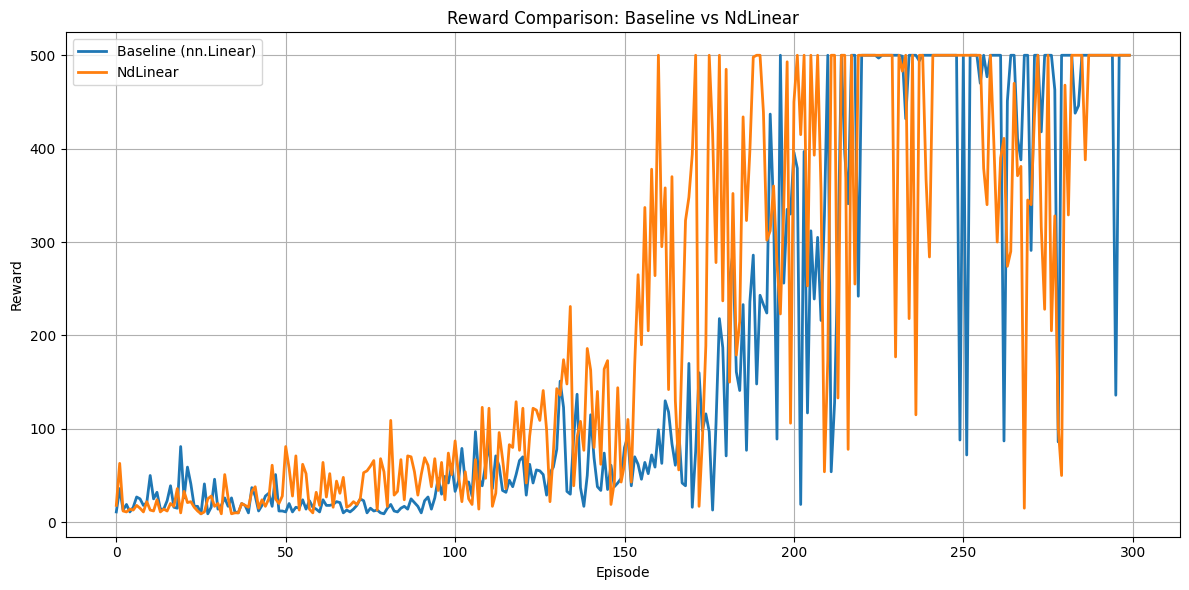

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(rewards_baseline, label='Baseline (nn.Linear)', linewidth=2)
plt.plot(nd_rewards, label='NdLinear', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Comparison: Baseline vs NdLinear')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import time
import numpy as np
import torch

def measure_latency(model, env, device='cpu', runs=100):
    model.eval()

    reset_result = env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
    state = np.array(state, dtype=np.float32)
    state = torch.FloatTensor(state).unsqueeze(0).to(device)

    # Warm-up
    for _ in range(10):
        _ = model(state)

    times = []
    with torch.no_grad():
        for _ in range(runs):
            start = time.time()
            _ = model(state)
            end = time.time()
            times.append(end - start)

    avg_latency = sum(times) / len(times)
    print(f"Average Latency over {runs} runs: {avg_latency*1000:.4f} ms")
    return avg_latency


In [12]:
measure_latency(baseline_model, env)
measure_latency(nd_model, env)


Average Latency over 100 runs: 0.0758 ms
Average Latency over 100 runs: 0.1158 ms


0.00011584997177124024

In [13]:
from torchsummary import summary

input_dim = env.observation_space.shape[0]

print(" Baseline Model (nn.Linear):")
summary(baseline_model, input_size=(input_dim,))

print("\n NdLinear Model:")
summary(nd_model, input_size=(input_dim,))



 Baseline Model (nn.Linear):
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
              ReLU-2                  [-1, 128]               0
            Linear-3                    [-1, 2]             258
Total params: 898
Trainable params: 898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------

 NdLinear Model:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
          NdLinear-2                  [-1, 128]               0
              ReLU-3                  [-1, 128]               0
  

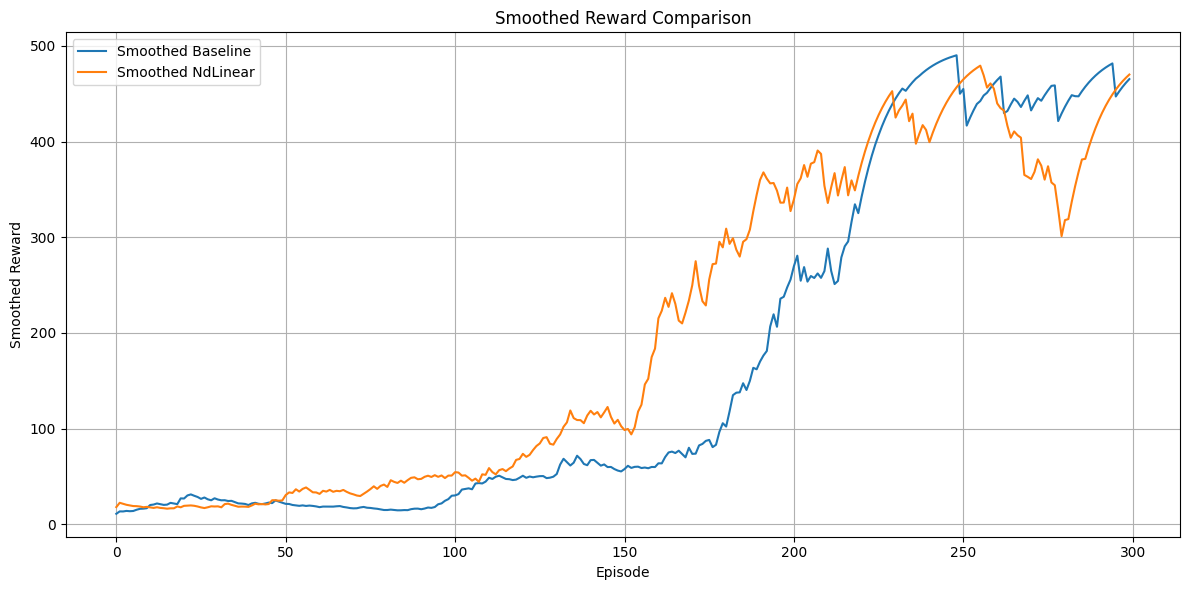

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def smooth(data, weight=0.9):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

smoothed_base = smooth(rewards_baseline)
smoothed_nd = smooth(nd_rewards)

plt.figure(figsize=(12, 6))
plt.plot(smoothed_base, label="Smoothed Baseline")
plt.plot(smoothed_nd, label="Smoothed NdLinear")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.title("Smoothed Reward Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


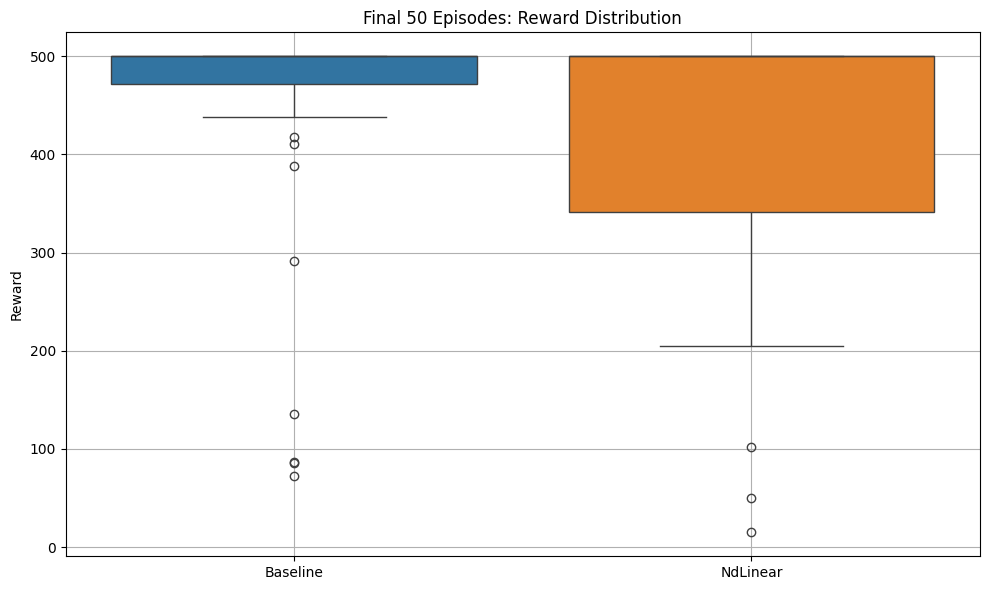

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select last 50 episodes from each model
last_50_baseline = rewards_baseline[-50:]
last_50_nd = nd_rewards[-50:]

plt.figure(figsize=(10, 6))
sns.boxplot(data=[last_50_baseline, last_50_nd])
plt.xticks([0, 1], ['Baseline', 'NdLinear'])
plt.ylabel('Reward')
plt.title('Final 50 Episodes: Reward Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
def run_baseline(env, episodes=300, batch_size=64, lr=1e-3):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import random
    import numpy as np
    import time
    from collections import deque

    # Patch for NumPy bool8 issue
    if not hasattr(np, 'bool8'):
        np.bool8 = np.bool_

    class DQN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(DQN, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Linear(128, output_dim)
            )

        def forward(self, x):
            return self.net(x)

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DQN(input_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    memory = deque(maxlen=10000)

    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01

    rewards_base = []
    episode_times = []
    episode_lengths = []

    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.randrange(output_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            return model(state).argmax().item()

    def train_step():
        if len(memory) < batch_size:
            return
        batch = random.sample(memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = model(states).gather(1, actions)
        with torch.no_grad():
            max_next_q = model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * gamma * max_next_q

        loss = criterion(q_values.squeeze(), target_q)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for ep in range(episodes):
        start_time = time.time()

        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        total_reward = 0
        done = False
        step_count = 0

        while not done:
            action = select_action(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            memory.append((state, action, reward, next_state, float(done)))
            state = next_state
            total_reward += reward
            step_count += 1
            train_step()

        end_time = time.time()
        episode_times.append(end_time - start_time)
        episode_lengths.append(step_count)
        rewards_base.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        print(f"[Baseline] Episode {ep + 1}, Reward: {total_reward}, Steps: {step_count}, Time: {end_time - start_time:.4f}s")

    return model, rewards_base, episode_times, episode_lengths


In [17]:
baseline_model, rewards_baseline, times_baseline, steps_baseline = run_baseline(env)


[Baseline] Episode 1, Reward: 19.0, Steps: 19, Time: 0.0005s
[Baseline] Episode 2, Reward: 25.0, Steps: 25, Time: 0.0005s
[Baseline] Episode 3, Reward: 11.0, Steps: 11, Time: 0.0003s
[Baseline] Episode 4, Reward: 13.0, Steps: 13, Time: 0.0181s
[Baseline] Episode 5, Reward: 10.0, Steps: 10, Time: 0.0268s
[Baseline] Episode 6, Reward: 14.0, Steps: 14, Time: 0.0375s
[Baseline] Episode 7, Reward: 15.0, Steps: 15, Time: 0.0393s
[Baseline] Episode 8, Reward: 15.0, Steps: 15, Time: 0.0337s
[Baseline] Episode 9, Reward: 17.0, Steps: 17, Time: 0.0402s
[Baseline] Episode 10, Reward: 21.0, Steps: 21, Time: 0.0578s
[Baseline] Episode 11, Reward: 38.0, Steps: 38, Time: 0.0928s
[Baseline] Episode 12, Reward: 20.0, Steps: 20, Time: 0.0448s
[Baseline] Episode 13, Reward: 15.0, Steps: 15, Time: 0.0226s
[Baseline] Episode 14, Reward: 21.0, Steps: 21, Time: 0.0335s
[Baseline] Episode 15, Reward: 12.0, Steps: 12, Time: 0.0240s
[Baseline] Episode 16, Reward: 17.0, Steps: 17, Time: 0.0265s
[Baseline] Episod

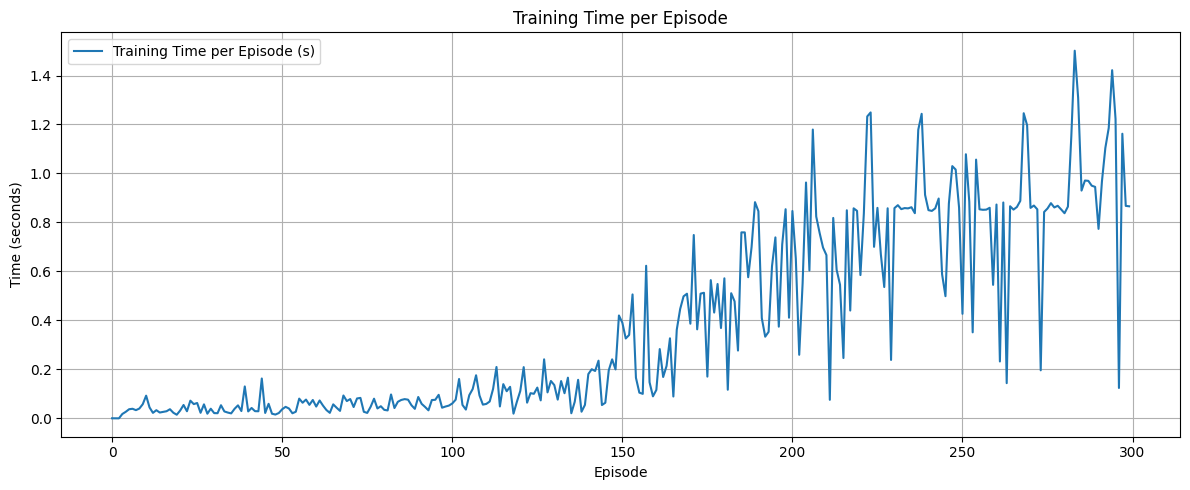

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(times_baseline, label='Training Time per Episode (s)')
plt.xlabel("Episode")
plt.ylabel("Time (seconds)")
plt.title("Training Time per Episode")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
!pip install ptflops


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [20]:
from ptflops import get_model_complexity_info

def print_model_flops(model, input_dim):
    model.eval()
    with torch.cuda.device(0 if torch.cuda.is_available() else -1):
        flops, params = get_model_complexity_info(
            model,
            (input_dim,),  # shape: (features,)
            as_strings=True,
            print_per_layer_stat=True,
            verbose=True
        )
    print(f"\nTotal Parameters: {params}")
    print(f"Total FLOPs: {flops}")


In [21]:
input_dim = env.observation_space.shape[0]

print(" Baseline Model (nn.Linear):")
print_model_flops(baseline_model, input_dim)

print("\n NdLinear Model:")
print_model_flops(nd_model, input_dim)


 Baseline Model (nn.Linear):
DQN(
  898, 100.000% Params, 1.03 KMac, 88.908% MACs, 
  (net): Sequential(
    898, 100.000% Params, 1.03 KMac, 88.908% MACs, 
    (0): Linear(640, 71.269% Params, 640.0 Mac, 55.459% MACs, in_features=4, out_features=128, bias=True)
    (1): ReLU(0, 0.000% Params, 128.0 Mac, 11.092% MACs, )
    (2): Linear(258, 28.731% Params, 258.0 Mac, 22.357% MACs, in_features=128, out_features=2, bias=True)
  )
)

Total Parameters: 898
Total FLOPs: 1.15 KMac

 NdLinear Model:
DQN_NdLinear(
  898, 100.000% Params, 1.03 KMac, 88.908% MACs, 
  (net): Sequential(
    898, 100.000% Params, 1.03 KMac, 88.908% MACs, 
    (0): NdLinear(
      640, 71.269% Params, 640.0 Mac, 55.459% MACs, 
      (relu): ReLU(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
      (align_layers): ModuleList(
        (0): Linear(640, 71.269% Params, 640.0 Mac, 55.459% MACs, in_features=4, out_features=128, bias=True)
      )
    )
    (1): ReLU(0, 0.000% Params, 128.0 Mac, 11.092% MACs, )
    (2): NdLine

[CPU] Episode 1, Reward: 17.0, CPU: 0.00%
[CPU] Episode 2, Reward: 12.0, CPU: 0.00%
[CPU] Episode 3, Reward: 26.0, CPU: 100.00%
[CPU] Episode 4, Reward: 17.0, CPU: 100.00%
[CPU] Episode 5, Reward: 14.0, CPU: 100.00%
[CPU] Episode 6, Reward: 17.0, CPU: 100.00%
[CPU] Episode 7, Reward: 24.0, CPU: 100.00%
[CPU] Episode 8, Reward: 15.0, CPU: 100.00%
[CPU] Episode 9, Reward: 15.0, CPU: 100.00%
[CPU] Episode 10, Reward: 16.0, CPU: 100.00%
[CPU] Episode 11, Reward: 23.0, CPU: 100.00%
[CPU] Episode 12, Reward: 17.0, CPU: 100.00%
[CPU] Episode 13, Reward: 15.0, CPU: 100.00%
[CPU] Episode 14, Reward: 11.0, CPU: 100.00%
[CPU] Episode 15, Reward: 15.0, CPU: 100.00%
[CPU] Episode 16, Reward: 17.0, CPU: 100.00%
[CPU] Episode 17, Reward: 12.0, CPU: 100.00%
[CPU] Episode 18, Reward: 15.0, CPU: 100.00%
[CPU] Episode 19, Reward: 10.0, CPU: 100.00%
[CPU] Episode 20, Reward: 38.0, CPU: 100.00%
[CPU] Episode 21, Reward: 18.0, CPU: 100.00%
[CPU] Episode 22, Reward: 9.0, CPU: 100.00%
[CPU] Episode 23, Reward

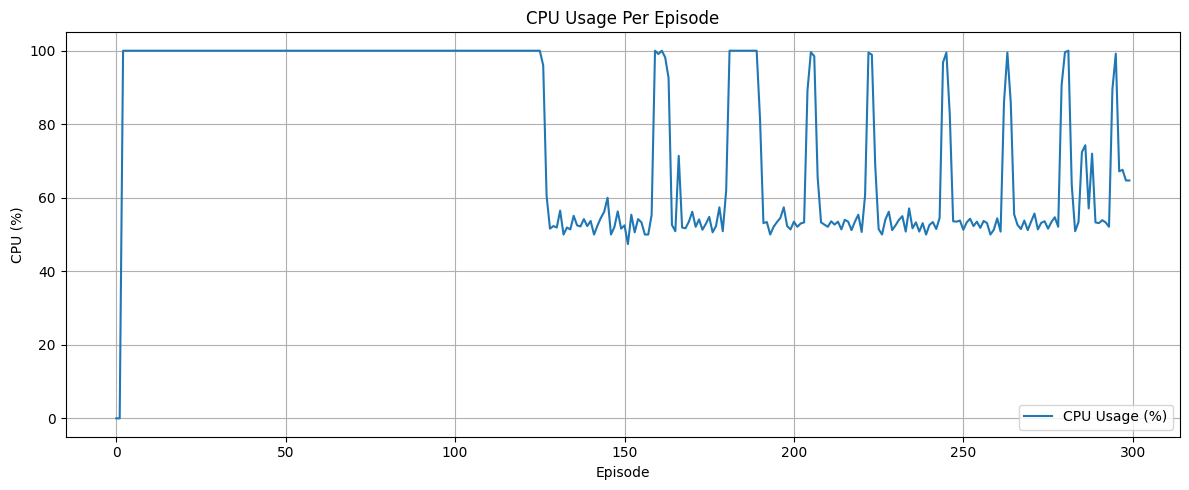

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import time
import psutil
import gym
import matplotlib.pyplot as plt
from collections import deque

def run_cpu_profiled_baseline(env, episodes=300, batch_size=64, lr=1e-3):
    if not hasattr(np, 'bool8'):
        np.bool8 = np.bool_

    class DQN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(DQN, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Linear(128, output_dim)
            )
        def forward(self, x):
            return self.net(x)

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DQN(input_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    memory = deque(maxlen=10000)

    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01

    rewards = []
    cpu_usage = []

    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.randrange(output_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            return model(state).argmax().item()

    def train_step():
        if len(memory) < batch_size:
            return
        batch = random.sample(memory, batch_size)
        states, actions, rewards_b, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards_b = torch.FloatTensor(rewards_b).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = model(states).gather(1, actions)
        with torch.no_grad():
            max_next_q = model(next_states).max(1)[0]
            target_q = rewards_b + (1 - dones) * gamma * max_next_q

        loss = criterion(q_values.squeeze(), target_q)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for ep in range(episodes):
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
        total_reward = 0
        done = False

        # Start CPU tracking
        psutil.cpu_percent(interval=None)

        while not done:
            action = select_action(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            memory.append((state, action, reward, next_state, float(done)))
            state = next_state
            total_reward += reward
            train_step()

        cpu_percent_after = psutil.cpu_percent(interval=None)
        cpu_usage.append(cpu_percent_after)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards.append(total_reward)
        print(f"[CPU] Episode {ep + 1}, Reward: {total_reward}, CPU: {cpu_percent_after:.2f}%")

    return model, rewards, cpu_usage

# Create the environment and run
env = gym.make("CartPole-v1", new_step_api=True)
model, rewards, cpu_usage = run_cpu_profiled_baseline(env)

# Plot CPU usage
plt.figure(figsize=(12, 5))
plt.plot(cpu_usage, label="CPU Usage (%)")
plt.xlabel("Episode")
plt.ylabel("CPU (%)")
plt.title("CPU Usage Per Episode")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
